# Model training, deploying and making on-chain prediction

This notebook includes information on how to prepare (load and transform) your data to train a deep neural network, deploy the model on-chain and how to use it. We split the content into:
1. Train the model using a wide-known dataset, official dataset supported by tensorflow, or keras.
2. Train the model using a custom visual dataset.
3. Deploy on-chain models.
4. Make prediction.

### Data preparation

In general, the target of data preparation step is to create sample data and groundtruth (X, y). By best practice, a dataset should be split into train (ratio%) and validation ((1 - ratio)%) subsets for training and validating progress. Let's clarify first the final artifact of this step:
- Training set: include X_train, y_train
- Validation set: include X_val, y_val

**The ratio of samples between validation and training set is up to you!** 

## 0. Requirement

Some dependencies need to be installed first:
- numpy 
- opencv-python
- tensorflow==2.16.1
- keras
- matplotlib (for visualization)
- tqdm (for progress bar)

Run:

In [ ]:
!python -m pip install numpy opencv-python tensorflow==2.16.1 keras matplotlib tqdm

Then, make sure all of them are imported on your script file:

In [1]:
import numpy as np
import os
import keras
from keras import layers

Now, let's define model factories for trying in the next sections

In [2]:
# create lenet 5 architecture for classification
def create_lenet5_for_classification(input_shape, num_classes, dense_cfg=[]):
    return keras.Sequential(
        [
            layers.InputLayer(shape=input_shape),
            layers.Conv2D(8, kernel_size=(3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            *[layers.Dense(units, activation="relu") for units in dense_cfg],
            layers.Dense(num_classes, activation="softmax"),
        ]
    )

# Create a simple MLP model for classification
def create_mlp(input_shape, dense_cfg=[]):
    return keras.Sequential(
        [
            layers.InputLayer(shape=input_shape),
            layers.Flatten(),
            *[layers.Dense(units, activation="relu") for units in dense_cfg],
            layers.Dense(10, activation="softmax"),
        ]
    )

## 1. Train the model using a wide-known dataset

Tensorflow and keras provide us instant API for loading the data as numpy data, sometime already normalized. These APIs help us to quick try a model architecture on a standard dataset to solve a common problem. For instant, I want to use MNIST dataset, for practice purpose, then:

In [3]:
# load the preprocessed dataset from keras
mnist_data = keras.datasets.mnist.load_data()

In [4]:
# mnist_data has format (x_train, y_train), (x_test, y_test), now we unpack it
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist_data 
print('Shape:', mnist_x_train.shape, mnist_y_train.shape, mnist_x_test.shape, mnist_y_test.shape)

Shape: (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [5]:
# mnist dataset has labels for 10 classes are 10 digits, from 0-9
mnist_labels = [str(i) for i in range(10)]

# mnist dataset by keras is shaped [28, 28] each item, has value range in [0, 255].
# then, we have to transform and normalize it before usage 
mnist_x_train = mnist_x_train.astype(np.float32) / 255.0 
mnist_x_test = mnist_x_test.astype(np.float32) / 255.0

# the operation is actually max, min scale. but the max is always 255 and the min value is always 0,
# so we just need to divide the x_train and x_test by 255 in this case
# for other tasks, it should be: x_norm = (x - min) / (max - min)

print('x_train\'s value range:', mnist_x_train.min(), mnist_x_train.max())
print('x_test\'s value range:', mnist_x_test.min(), mnist_x_test.max())

x_train's value range: 0.0 1.0
x_test's value range: 0.0 1.0


In [6]:
# as the standard, input of keras model must includes one channel dim. 
# So, we need to expand the last dimension to form a pseudo channel dim

mnist_x_train = np.expand_dims(mnist_x_train, -1) # -1 is the last dim
mnist_x_test = np.expand_dims(mnist_x_test, -1) # -1 is the last dim

print('Shape:', mnist_x_train.shape, mnist_y_train.shape, mnist_x_test.shape, mnist_y_test.shape)

Shape: (60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [7]:
# In total, we have

print(mnist_x_train.shape[0], 'training samples.')
print(mnist_x_test.shape[0], 'testing samples.')

60000 training samples.
10000 testing samples.


In [8]:
# now create a lenet model and try it

lenet5_mnist = create_lenet5_for_classification(
    mnist_x_train.shape[1:], 
    len(mnist_labels)
)

lenet5_mnist.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

lenet5_mnist.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,098 (35.54 KB)

 Trainable params: 9,098 (35.54 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# train the model 

lenet5_mnist.fit(
    mnist_x_train, 
    keras.utils.to_categorical(
        mnist_y_train, 
        len(mnist_labels)
    ),
    batch_size=128, # my pc is strong so i set it to 128. it should be lower for weaker pc
    epochs=5, 
    validation_split=0.1 # validation directly on the train set. notice that the train set will be separated into 2 parts: train and validation
)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5813 - loss: 0.2409 - val_accuracy: 0.9522 - val_loss: 0.0413
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9456 - loss: 0.0435 - val_accuracy: 0.9685 - val_loss: 0.0286
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9652 - loss: 0.0296 - val_accuracy: 0.9777 - val_loss: 0.0219
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9720 - loss: 0.0239 - val_accuracy: 0.9837 - val_loss: 0.0181
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9765 - loss: 0.0206 - val_accuracy: 0.9813 - val_loss: 0.0168


In [10]:
# eval on test set

test_loss, test_acc = lenet5_mnist.evaluate(
    mnist_x_test,
    keras.utils.to_categorical(
        mnist_y_test,
        len(mnist_labels)
    )
)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9747 - loss: 0.0206
Test accuracy: 0.9793999791145325
Test loss: 0.017507128417491913


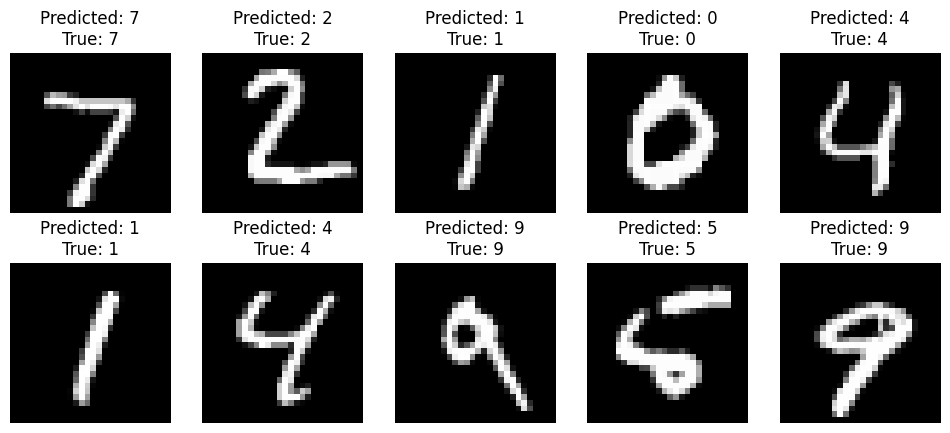

In [11]:
# visualize the result

from matplotlib import pyplot as plt 

n = 10
plt.figure(figsize=(12, 5))
for i in range(n):
    plt.subplot(2, 5, i + 1)
    plt.imshow(mnist_x_test[i].reshape(28, 28), cmap='gray')
    plt.title('Predicted: {}\nTrue: {}'.format(
        mnist_labels[np.argmax(lenet5_mnist.predict(mnist_x_test[i:i+1], verbose=None))],
        mnist_labels[mnist_y_test[i]]
    ))
    plt.axis('off')
plt.show()


looks good!

## 2. Train the model using a custom visual dataset

This section is to help you create a training data for a specific task. The sample I use is to categorize dog and cat images using lenet5 model.

In [12]:
# at first, download it from the gdrive id
# install gdown: python -m pip install gdown

if not os.path.exists('cat-dog.zip'):
    !gdown  1FP3NB3diInw-kIno5aU3w7DAZUaKFWla -O cat-dog.zip

    import zipfile

    assert os.path.exists('cat-dog.zip'), 'File not found'
    with zipfile.ZipFile('cat-dog.zip', 'r') as zip_ref:
        zip_ref.extractall('cat-dog-dataset')

In [13]:
# the train data file has fmt label.<id>.jpg
# now define a function to load it

import re, cv2, glob

pattern = re.compile(r'(\w+)\.(\d+)\.jpg')

labels_map = {
    'cat': 0,
    'dog': 1
}

def load_item(path):
    name = os.path.split(path)[-1]
    label, _ = pattern.match(name).groups()
    return cv2.imread(path), labels_map[label]

In [14]:
# index data files, load and split 

train_files = glob.glob('cat-dog-dataset/train/*.jpg')
print('Total data files:', len(train_files)) 

train_ratio = .7
train_files = np.random.permutation(train_files)

train_files = train_files[:int(len(train_files) * train_ratio)]
val_files = train_files[int(len(train_files) * train_ratio):]

print('Train files:', len(train_files))
print('Validation files:', len(val_files))

Total data files: 25000
Train files: 17500
Validation files: 5250


In [15]:
# now we load and transform data manually

catdog_x_train, catdog_y_train, catdog_x_test, catdog_y_test = [], [], [], []
img_input_size = (64, 64) # we use larger image for this task


In [17]:
import tqdm 

for path in tqdm.tqdm(train_files, desc='Loading train data'):
    x, y = load_item(path)

    x = cv2.resize(x, img_input_size)

    catdog_x_train.append(x)
    catdog_y_train.append(y)

for path in tqdm.tqdm(val_files, desc='Loading validation data'):
    x, y = load_item(path)

    x = cv2.resize(x, img_input_size)

    catdog_x_test.append(x)
    catdog_y_test.append(y)

# construct np.arrays for the next steps
catdog_x_train = np.array(catdog_x_train)
catdog_y_train = np.array(catdog_y_train)
catdog_x_test = np.array(catdog_x_test)
catdog_y_test = np.array(catdog_y_test)

print('Shape:', catdog_x_train.shape, catdog_y_train.shape, catdog_x_test.shape, catdog_y_test.shape)

Loading validation data: 100%|██████████| 5250/5250 [00:05<00:00, 1024.39it/s]

Shape: (17500, 64, 64, 3) (17500,) (5250, 64, 64, 3) (5250,)


In [18]:
# now normalize the data

catdog_x_train = catdog_x_train.astype(np.float32) / 255.0
catdog_x_test = catdog_x_test.astype(np.float32) / 255.0

In [19]:
print('Value range:', catdog_x_train.min(), catdog_x_train.max(), catdog_x_test.min(), catdog_x_test.max())
print('Shape:', catdog_x_train.shape, catdog_y_train.shape, catdog_x_test.shape, catdog_y_test.shape)

Value range: 0.0 1.0 0.0 1.0
Shape: (17500, 64, 64, 3) (17500,) (5250, 64, 64, 3) (5250,)


In [20]:
# create a lenet model 
# in this task, the input is 3-channel image, so we have to change the input shape

lenet5_catdog = create_lenet5_for_classification(
    catdog_x_train.shape[1:],
    len(labels_map),
    dense_cfg=[64]
)

lenet5_catdog.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

lenet5_catdog.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,730 (1.01 MB)

 Trainable params: 263,730 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# train the model

lenet5_catdog.fit(
    catdog_x_train,
    keras.utils.to_categorical(catdog_y_train, len(labels_map)),
    batch_size=128,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5419 - loss: 0.6872 - val_accuracy: 0.6380 - val_loss: 0.6368
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6565 - loss: 0.6108 - val_accuracy: 0.6674 - val_loss: 0.5991
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7064 - loss: 0.5633 - val_accuracy: 0.6957 - val_loss: 0.5797
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7372 - loss: 0.5282 - val_accuracy: 0.7003 - val_loss: 0.5689
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7616 - loss: 0.4983 - val_accuracy: 0.7366 - val_loss: 0.5270
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7790 - loss: 0.4672 - val_accuracy: 0.7423 - val_loss: 0.5151
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7836 - loss: 0.4576 - val_accuracy: 0.7443 - val_loss: 0.5161
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8043 - loss: 0.4241 - val_accuracy: 0.

In [22]:
# now we test it

test_loss, test_acc = lenet5_catdog.evaluate(
    catdog_x_test,
    keras.utils.to_categorical(catdog_y_test, len(labels_map))
)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8030 - loss: 0.4196
Test accuracy: 0.7832381129264832
Test loss: 0.4522818922996521


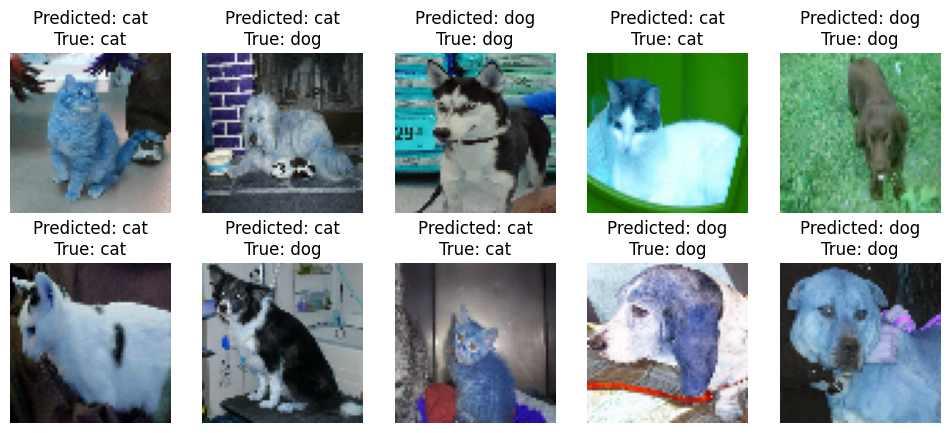

In [23]:
# visualize the result

n = 10
plt.figure(figsize=(12, 5))

for i in range(n):
    plt.subplot(2, 5, i + 1)
    plt.imshow(catdog_x_test[i])
    plt.title('Predicted: {}\nTrue: {}'.format(
        list(labels_map.keys())[np.argmax(lenet5_catdog.predict(catdog_x_test[i:i+1], verbose=None))],
        list(labels_map.keys())[catdog_y_test[i]]
    ))
    plt.axis('off')

## 3. Deploy on-chain models.

Ensure your model must be a Keras model. Moreover, It should be trained before saving it on-chain. This step requires help from our development pack. Install it via pip:

In [24]:
!pip install git+https://github.com/eternalai-org/eternalai.git@v1.0.0

  Cloning https://github.com/eternalai-org/dev-eternalai.git to xxxxx\appdata\local\temp\pip-req-build-lg9q2s1d
  Resolved https://github.com/eternalai-org/dev-eternalai.git to commit 140c8d5e77dd1f180ef0e1c2ac7c20562ea43321
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached loguru-0.7.2-py3-none-any.whl.metadata (23 kB)
  Using cached web3-6.20.0-py3-none-any.whl.metadata (4.5 kB)
  Using cached load_dotenv-0.1.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached win32_setctime-1.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached aiohttp-3.9.5-cp310-cp310-win_amd64.whl.metadata (7.7 kB)
  Using cached eth_abi-5.1.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached eth_account-0.12.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached eth_hash-0.7.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached eth_typing-4.4.0-py3-none-any.whl.metadata (5.1 kB)
  U

  Running command git clone --filter=blob:none --quiet https://github.com/eternalai-org/dev-eternalai.git 'xxxxx\AppData\Local\Temp\pip-req-build-lg9q2s1d'


In [25]:
# just to make sure the installation was successful:

!eai version

2024-07-10 15:42:09 | WARNING  | eai:<module>:6 - .env file not found, please run command 'eai set-private-key' to set your private key
2024-07-10 15:42:11 | SUCCESS  | eai.cli:main:159 - ✨ EternalAI Toolkit - Version: 1.0.0 ✨


In [26]:
# once step initialization

!eai set-private-key --private-key <private-key>

2024-07-10 15:42:12 | WARNING  | eai:<module>:6 - .env file not found, please run command 'eai set-private-key' to set your private key
2024-07-10 15:42:14 | INFO     | eai.cli:set_private_key:74 - Setting private key ...
2024-07-10 15:42:14 | SUCCESS  | eai.cli:set_private_key:84 - Private key set successfully.


In [27]:
# import the toolkit 

import eai

In [28]:
lenet5_mnist_onchain_model = eai.publish(
    lenet5_mnist, 
    model_name = "lenet5_mnist_202407"
)

2024-07-10 15:42:15 | INFO     | eai.exporter:_export_tf_model:174 - Exporting Tensorflow/Keras model ...
2024-07-10 15:42:15 | INFO     | eai.exporter:_export_model_graph:65 - Exporting model graph ...
2024-07-10 15:42:15 | SUCCESS  | eai.exporter:_export_model_graph:85 - Layer InputLayer exported
2024-07-10 15:42:15 | SUCCESS  | eai.exporter:_export_model_graph:85 - Layer Conv2D exported
2024-07-10 15:42:15 | SUCCESS  | eai.exporter:_export_model_graph:85 - Layer MaxPooling2D exported
2024-07-10 15:42:15 | SUCCESS  | eai.exporter:_export_model_graph:85 - Layer Conv2D exported
2024-07-10 15:42:15 | SUCCESS  | eai.exporter:_export_model_graph:85 - Layer MaxPooling2D exported
2024-07-10 15:42:15 | SUCCESS  | eai.exporter:_export_model_graph:85 - Layer Flatten exported
2024-07-10 15:42:15 | SUCCESS  | eai.exporter:_export_model_graph:85 - Layer Dense exported
2024-07-10 15:42:15 | SUCCESS  | eai.exporter:_export_model_graph:126 - Model graph exported.
2024-07-10 15:42:15 | INFO     | eai

In [34]:
lenet5_dogcat_onchain_model = eai.publish(
    lenet5_catdog,
    model_name = "lenet5_dogcat_202407"
)

2024-07-10 15:46:41 | INFO     | eai.exporter:_export_tf_model:174 - Exporting Tensorflow/Keras model ...
2024-07-10 15:46:41 | INFO     | eai.exporter:_export_model_graph:65 - Exporting model graph ...
2024-07-10 15:46:41 | SUCCESS  | eai.exporter:_export_model_graph:85 - Layer InputLayer exported
2024-07-10 15:46:41 | SUCCESS  | eai.exporter:_export_model_graph:85 - Layer Conv2D exported
2024-07-10 15:46:41 | SUCCESS  | eai.exporter:_export_model_graph:85 - Layer MaxPooling2D exported
2024-07-10 15:46:41 | SUCCESS  | eai.exporter:_export_model_graph:85 - Layer Conv2D exported
2024-07-10 15:46:41 | SUCCESS  | eai.exporter:_export_model_graph:85 - Layer MaxPooling2D exported
2024-07-10 15:46:41 | SUCCESS  | eai.exporter:_export_model_graph:85 - Layer Flatten exported
2024-07-10 15:46:41 | SUCCESS  | eai.exporter:_export_model_graph:85 - Layer Dense exported
2024-07-10 15:46:41 | SUCCESS  | eai.exporter:_export_model_graph:85 - Layer Dense exported
2024-07-10 15:46:41 | SUCCESS  | eai.e

## 4. Make on-chain prediction

Ensure your `input_tensor` is preprocessed to match the model’s expected input format.

In [39]:
sample = mnist_x_test[0]
print(sample.shape)
print(sample.dtype)

(28, 28, 1)
float32


In [40]:
print("Lenet5 mnist model address:", lenet5_mnist_onchain_model.get_address())

Lenet5 mnist model address: 0xA0C80DFd6928700f7683Ed2f0364A39cab556C65


In [41]:
output_tensor = lenet5_mnist_onchain_model.predict([sample])
print('Predicted:', mnist_labels[np.argmax(output_tensor)])

Predicted: 7


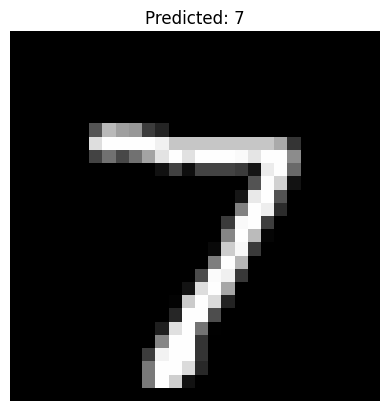

In [42]:
# let's check
plt.imshow(sample.reshape(28, 28), cmap='gray')
plt.title('Predicted: {}'.format(mnist_labels[np.argmax(output_tensor)]))
plt.axis('off')
plt.show()